# Analysis of the screening results
---

This notebook evaluates the results of the specificity screen. For the screen we trained an Ensemble of two Resnet18 pretrained on the Imagenet data set that processed the individual single-nuclei images as well as whole FoV images. The latter model can use the whole FoV images to also derive distributional information like e.g. the cell density that might be helpful to distinguish the negative control setting from the OE condition. Note that while the illumination has been corrected for there might still be related artifacts that the model potential could overfit on.

First, single nuclei and FoV images are scaled by subtracting the 0.1 percentile and dividing the image by the 99.9 percentile to make the images comparable and limit the influence of oversaturated artifacts. The images are clipped such that the values are within 0,1 respectively 0, 255 after rescaling the images to 8-bit integer range.

We augmented the single nuclei images by resizing them from 96x96 to 224x224 and randomly flipping them horizontally and vertically before forming pseudo-RGB images and normalizing those using the mean and standard deviations of the ImageNet data set. 

Additionally for each nuclei we obtained the corresponding FoV image by cropping the 1080x1080 centered around the nuclei for a patch size of 448x448. If required the FoV image is padded with the lower percentile value before. The crops are then also randomly flipped during training, transformed into pseudo-RGBs and normalized.


In this notebook, we will first compare the model with the results of a similar screen run only on the single-nuclei images processed as described above by a pretrained ResNet18 model. Second, we will compare the results of such screen using the morphological embeddings computed by the authors of the original publication. Third, using a automatic approach we will identify a subset of OE conditions that yield to a reproducible and specific structural phenotype in the cell populations different from the negative controls by thresholding a defined specificity score.
The final evaluation of the selected set of OE condition targets will conclude this analysis.

## 0. Environmental setup

In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import venn
from typing import List
from umap import UMAP
import os
from scipy.stats import pearsonr
from kneed import KneeLocator
from loess import loess_1d

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from statannot import add_stat_annotation

import sys

sys.path.append("../../../")

from src.utils.basic.io import get_file_list
from src.utils.notebooks.images.exp_evaluation import analyze_screen_results

%load_ext nb_black
%autosave 60

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


Autosaving every 60 seconds


<IPython.core.display.Javascript object>

In [166]:
def plot_spec_screen_results(
    root_dir: str,
    dataset_types: List[str],
    score_df: pd.DataFrame,
    label_col: str = "labels",
    figsize=[12, 6],
    filter_targets=None,
):
    subdirs = sorted(os.listdir(root_dir))
    for subdir in tqdm(subdirs, desc="Visualize latent spaces"):
        if filter_targets is None or subdir in filter_targets:
            fig, ax = plt.subplots(ncols=len(dataset_types), figsize=figsize)
            ax = ax.flatten()
            all_latents = []
            all_labels = []
            dataset_labels = []
            for i in range(len(dataset_types)):
                dataset_type = dataset_types[i]
                latents = pd.read_hdf(
                    os.path.join(root_dir, subdir, dataset_type + "_latents.h5")
                )
                all_labels.append(
                    np.array(
                        latents.loc[:, "labels"].map(
                            dict(zip([0, 1], sorted(["EMPTY", subdir.upper()])))
                        )
                    )
                )
                all_latents.append(np.array(latents.drop(columns=[label_col])))
                dataset_labels.extend([dataset_type] * len(latents))

            all_latents = np.concatenate(all_latents)
            all_labels = np.concatenate(all_labels)
            all_embs = TSNE(random_state=1234).fit_transform(all_latents)
            all_embs = pd.DataFrame(all_embs, columns=["tsne_0", "tsne_1"])
            all_embs["label"] = all_labels
            all_embs["dataset_type"] = np.array(dataset_labels)

            for i in range(len(dataset_types)):
                dataset_type = dataset_types[i]
                ax[i] = sns.scatterplot(
                    data=all_embs.loc[all_embs["dataset_type"] == dataset_type],
                    x="tsne_0",
                    y="tsne_1",
                    hue="label",
                    ax=ax[i],
                    hue_order=["EMPTY", subdir.upper()],
                    s=4,
                )
                score = score_df.loc[subdir.upper(), "{}_acc".format(dataset_type)]
                ax[i].set_title("{} data, acc: {:.4f}".format(dataset_type, score))
                ax[i].set_xlim([all_embs.tsne_0.min() - 20, all_embs.tsne_0.max() + 20])
                ax[i].set_ylim([all_embs.tsne_1.min() - 20, all_embs.tsne_1.max() + 20])

            fig.suptitle("Latent embeddings for {}".format(subdir))
            plt.show()
            plt.close()

<IPython.core.display.Javascript object>

In [59]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1 :] / n

<IPython.core.display.Javascript object>

In [3]:
cell_cycle_genes = set(
    pd.read_csv(
        "../../../data/other/reactome_cell_cycle.txt", index_col=0, header=None
    ).index
)
chrom_org_genes = set(
    pd.read_csv(
        "../../../data/other/reactome_chrom_org.txt", index_col=0, header=None
    ).index
)
dna_repair_genes = set(
    pd.read_csv(
        "../../../data/other/reactome_dna_repair.txt", index_col=0, header=None
    ).index
)
reg_actin_cytoskeleton_genes = set(
    pd.read_csv(
        "../../../data/other/kegg_reg_act_cytoskeleton.txt", index_col=0, header=None
    ).index
)
human_tfs = set(
    list(
        pd.read_csv(
            "../../../data/other/human_tf_list.txt", index_col=0, header=None
        ).index
    )
)
curated_gene_sets = (
    cell_cycle_genes.union(chrom_org_genes)
    .union(dna_repair_genes)
    .union(reg_actin_cytoskeleton_genes)
    .union(human_tfs)
)

<IPython.core.display.Javascript object>

In [139]:
rohban_target_set = pd.read_csv(
    "../../../data/other/rhoban_specific_orf_targets.csv", index_col=0
)
rohban_targets = set(rohban_target_set.index)

<IPython.core.display.Javascript object>

---

## 1. Read in data

First, we will read in the data which automatically scans the given directories of the individual screens for the corresponding log-files and extract the different scores from those.

In [5]:
screen_results_multi_image = analyze_screen_results(
    "../../../data/experiments/image_embeddings/nuclei_fov_screen"
)
screen_results_morph_embs = analyze_screen_results(
    "../../../data/experiments/morph_embeddings/screen"
)
screen_results_nuclei = analyze_screen_results(
    "../../../data/experiments/image_embeddings/nuclei_screen"
)

<IPython.core.display.Javascript object>

---

## 2. Analyses

### 2.1. Exploratory analyses

After having read in the data, we will first compute specificity score for each target that is given by the minimum of the validation and testing accuracy. This is done to account for the high variability in the data that led to significant differences between the validation and testing performance. In an optimal setting we would choose the k-fold cross-validated score as the specificity score, however due to computational complexity we proceed with this simpler approach.

In [6]:
screen_results_multi_image["min_val_test_acc"] = [
    np.min(screen_results_multi_image.iloc[i, -2:])
    for i in range(len(screen_results_multi_image))
]
screen_results_nuclei["min_val_test_acc"] = [
    np.min(screen_results_nuclei.iloc[i, -2:])
    for i in range(len(screen_results_nuclei))
]
screen_results_morph_embs["min_val_test_acc"] = [
    np.min(screen_results_morph_embs.iloc[i, -2:])
    for i in range(len(screen_results_morph_embs))
]

<IPython.core.display.Javascript object>

Since, the input data was balanced by randomly undersampling the majority class, we expect a specificity score of around 0.5 to reflect random chance and hence no reproducible or no specific signal for the respective overexpression.

The plot below shows a rapid decrease in the specificity score for each of the different screening models using the morphological embeddings computed by Rohban et al. (2017), and the ResNet18 taking in the single nuclei images respectively a tuple of the single nuclei image and a patch centered at the single-nuclei location.

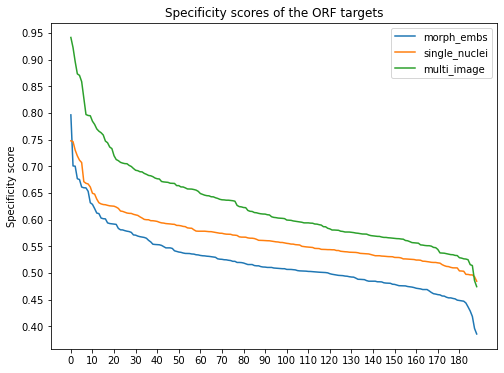

<IPython.core.display.Javascript object>

In [7]:
fig, ax = plt.subplots(figsize=[8, 6])
spec_scores = np.array(
    screen_results_morph_embs.sort_values(
        "min_val_test_acc", ascending=False
    ).min_val_test_acc
)
idx = np.array(list(range(len(spec_scores))))

plt.plot(idx, spec_scores, label="morph_embs")

spec_scores = np.array(
    screen_results_nuclei.sort_values(
        "min_val_test_acc", ascending=False
    ).min_val_test_acc
)
plt.plot(idx, spec_scores, label="single_nuclei")

spec_scores = np.array(
    screen_results_multi_image.sort_values(
        "min_val_test_acc", ascending=False
    ).min_val_test_acc
)
plt.plot(idx, spec_scores, label="multi_image")
plt.title("Specificity scores of the ORF targets")
plt.xticks(np.arange(0, 189, 10))
plt.yticks(np.arange(40, 100, 5) / 100)
plt.ylabel("Specificity score")
plt.legend()
plt.show()

We see that all of the curves show a fairly similar shape while the multi-image setup yields on average significantly higher scores. The comparability of the scores is also apparent when looking at the correlation of the individual specificity scores for any pair of the screening models.

In [8]:
common_targets = set(screen_results_multi_image.target).intersection(
    set(screen_results_nuclei.target).intersection(
        set(screen_results_morph_embs.target)
    )
)
comp_results = pd.DataFrame()
screen_results_multi_image.index = screen_results_multi_image.target
screen_results_nuclei.index = screen_results_nuclei.target
screen_results_morph_embs.index = screen_results_morph_embs.target

comp_results["multi_image_spec_score"] = screen_results_multi_image.loc[
    common_targets, "min_val_test_acc"
]
comp_results["nuclei_image_spec_score"] = screen_results_nuclei.loc[
    common_targets, "min_val_test_acc"
]
comp_results["morph_embs_spec_score"] = screen_results_morph_embs.loc[
    common_targets, "min_val_test_acc"
]
comp_results.index = common_targets
comp_results.head()

multi_image_spec_score  nuclei_image_spec_score  morph_embs_spec_score
MAPK9                0.550086                 0.496147               0.501803
DDIT3                0.594907                 0.540509               0.510995
MLST8                0.612689                 0.591734               0.385417
GRB10                0.610340                 0.572531               0.531250
RB1                  0.515417                 0.526182               0.503750

<IPython.core.display.Javascript object>

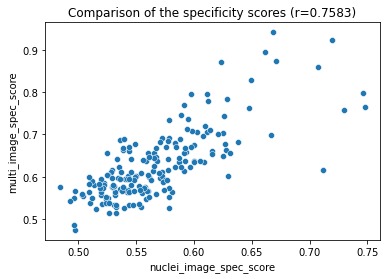

<IPython.core.display.Javascript object>

In [9]:
fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.scatterplot(
    data=comp_results, x="nuclei_image_spec_score", y="multi_image_spec_score"
)
plt.title(
    "Comparison of the specificity scores (r={})".format(
        np.round(
            pearsonr(
                comp_results.loc[:, "nuclei_image_spec_score"],
                comp_results.loc[:, "multi_image_spec_score"],
            )[0],
            4,
        )
    )
)
plt.show()

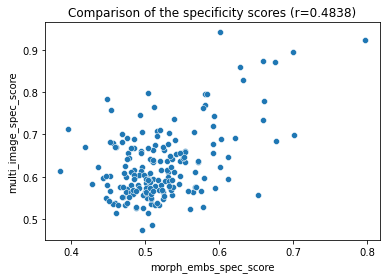

<IPython.core.display.Javascript object>

In [10]:
fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.scatterplot(
    data=comp_results, x="morph_embs_spec_score", y="multi_image_spec_score"
)
plt.title(
    "Comparison of the specificity scores (r={})".format(
        np.round(
            pearsonr(
                comp_results.loc[:, "morph_embs_spec_score"],
                comp_results.loc[:, "multi_image_spec_score"],
            )[0],
            4,
        )
    )
)
plt.show()

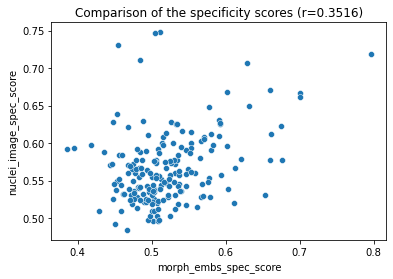

<IPython.core.display.Javascript object>

In [11]:
fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.scatterplot(
    data=comp_results, x="morph_embs_spec_score", y="nuclei_image_spec_score"
)
plt.title(
    "Comparison of the specificity scores (r={})".format(
        np.round(
            pearsonr(
                comp_results.loc[:, "morph_embs_spec_score"],
                comp_results.loc[:, "nuclei_image_spec_score"],
            )[0],
            4,
        )
    )
)
plt.show()

As seen above the computed specificity scores are as expected correlated for the single-nuclei image and multi-image inputs, less so when compared to the morphological embeddings. Since the latter are computed even for a different segmentation this is however expected.

Next, we will save the data to disk for further analyses.

In [12]:
screen_results_multi_image.to_csv(
    "../../../data/experiments/image_embeddings/nuclei_fov_screen/screen_results.csv"
)
screen_results_nuclei.to_csv(
    "../../../data/experiments/image_embeddings/nuclei_screen/screen_results.csv"
)
screen_results_morph_embs.to_csv(
    "../../../data/experiments/morph_embeddings/screen/screen_results.csv"
)

<IPython.core.display.Javascript object>

---

## 3. Validation of the specificity scores

Before we proceed further, we aim to validate our definition of the specifity score. To this end, we will look at the distribution of the respective score (from now on focussing on the multi-image input model-based screen) in different gene sets, i.e. one that describes the 76 genes that were identified as yielding specific and reproducible structural phenotypes upon overexpression of corresponding alleles in the study by Rohban et al. (2017) as well as a set obtained from the curation of multiple pathways that are expected to modulate the chromatin organization and cellular morphology.

In [13]:
spec_results = comp_results.copy()
spec_results["spec_score"] = spec_results.multi_image_spec_score

<IPython.core.display.Javascript object>

In [127]:
spec_results["rohban_selected"] = np.array(
    spec_results.index.isin(rohban_targets)
).astype("str")

spec_results["pathways_of_interest"] = np.array(
    spec_results.index.isin(curated_gene_sets)
).astype("str")

<IPython.core.display.Javascript object>

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: Mann-Whitney-Wilcoxon test smaller with Bonferroni correction, P_val=9.294e-06 U_stat=2.730e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: Mann-Whitney-Wilcoxon test smaller with Bonferroni correction, P_val=7.827e-03 U_stat=3.448e+03


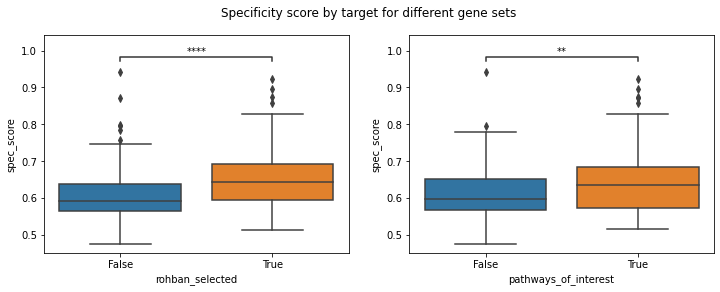

<IPython.core.display.Javascript object>

In [128]:
fig, ax = plt.subplots(ncols=2, figsize=[12, 4])
ax = ax.flatten()
ax[0] = sns.boxplot(
    data=spec_results,
    y="spec_score",
    x="rohban_selected",
    ax=ax[0],
    order=["False", "True"],
)
add_stat_annotation(
    ax[0],
    data=spec_results,
    x="rohban_selected",
    y="spec_score",
    box_pairs=[("True", "False")],
    test="Mann-Whitney-ls",
    text_format="star",
    loc="inside",
    order=["False", "True"],
)
ax[1] = sns.boxplot(
    data=spec_results,
    y="spec_score",
    x="pathways_of_interest",
    ax=ax[1],
    order=["False", "True"],
)
add_stat_annotation(
    ax[1],
    data=spec_results,
    x="pathways_of_interest",
    y="spec_score",
    box_pairs=[("False", "True")],
    test="Mann-Whitney-ls",
    text_format="star",
    loc="inside",
    order=["False", "True"],
)
fig.suptitle("Specificity score by target for different gene sets")
plt.show()

As seen above the specificity score is significantly higher for targets that are part of the mechano-transduction pathways and consistent with the work of Rohban et al. 2017.

---

## 4. Identifying specific ORF targets

Next, we will select a cut-off for the specificity score to identify a subset of ORF targets that yield a specific and reproducible structural phenotype upon overexpression. To this end, we will use the elbow method. We will first compute the loess smoothed curve of specificity scores in decreasing order and second identify the elbow of the specificity score curve using the kneedle algorithm using the recommened default parameters as described in Satopaa et al. (2011).

In [129]:
idx = np.arange(len(spec_results))
sorted_spec_scores = np.array(
    spec_results.sort_values("spec_score", ascending=False).spec_score
)

<IPython.core.display.Javascript object>

In [130]:
kneedle = KneeLocator(
    idx,
    sorted_spec_scores,
    curve="convex",
    online=False,
    direction="decreasing",
    S=2,
)

<IPython.core.display.Javascript object>

In [131]:
print(
    "Elbow found at: idx={}, spec_score={} ".format(
        kneedle.knee, sorted_spec_scores[kneedle.knee]
    ),
)

Elbow found at: idx=42, spec_score=0.67137097 


<IPython.core.display.Javascript object>

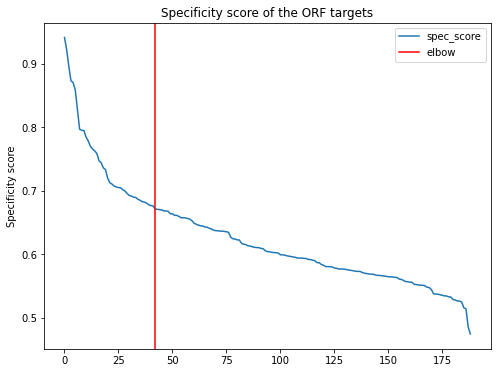

<IPython.core.display.Javascript object>

In [132]:
fig, ax = plt.subplots(figsize=[8, 6])
ax.plot(
    idx,
    sorted_spec_scores,
    label="spec_score",
)
ax.set_ylabel("Specificity score")
ax.set_title("Specificity score of the ORF targets")
ax.axvline(x=kneedle.knee, c="r", label="elbow")
plt.legend()
plt.show()

The algorithm identifies the elbow of the specificity score at 0.6714 for which 42 ORF targets show a score at least as good as that cutoff. The selected targets are shown below.

In [133]:
cutoff = sorted_spec_scores[kneedle.knee]
selected_targets = set(spec_results.loc[spec_results["spec_score"] >= cutoff].index)
print(selected_targets)

{'MKNK1', 'BAX', 'MAP2K3', 'RHOA', 'PRKACA', 'MAPK7', 'E2F1', 'EIF4EBP1', 'CASP8', 'SRC', 'SDHA', 'CREB1', 'JUN', 'TSC2', 'SREBF1', 'RAF1', 'PKIA', 'IKBKB', 'RELB', 'CEBPA', 'WWTR1', 'ELK1', 'CDKN1A', 'STK3', 'CXXC4', 'BCL2L11', 'MAP3K9', 'MYD88', 'PRKCE', 'ATF4', 'SMAD4', 'ERG', 'DIABLO', 'MAP3K2', 'IRAK4', 'ATF2', 'BRAF', 'CSNK1E', 'MOS', 'MAP3K5', 'AKT1S1', 'HRAS', 'CDC42'}


<IPython.core.display.Javascript object>

---

## 5. Validation of the specific ORF targets

To validate the final selection we will first compare the set of selected targets with the previously described gene sets from Rohban et al. and the mechano-transduction pathways.

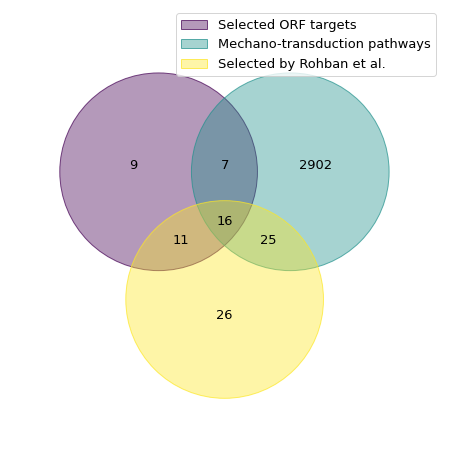

<IPython.core.display.Javascript object>

In [134]:
ax = venn.venn(
    dict(
        zip(
            [
                "Selected ORF targets",
                "Mechano-transduction pathways",
                "Selected by Rohban et al.",
            ],
            [
                selected_targets,
                curated_gene_sets,
                rohban_targets,
            ],
        )
    )
)

We find that for only 27/43 selected genes corresponding alleles were defined to provide a reproducible and specific structural phenotype upon overexpression. We will look in more detail into those that were not or additionally selected in the following. First, however it is important to point out the differences of our specificity screening approach and then applied by Rohban et al. (2017).

First, while we aim to identify genes that yield a specific structural signal and thus pool all data of the overexpression of different alleles of the same gene to construct one OE condition data set, Rohban et al. (2017) look at each gene individually. Thus, in their setting less number of samples are available per condition yet more conditions to be tested which reduces the power of statistical tests.

Second, Rohban et al. (2017) identify specific and reproducible OE conditions by identifying those for which the average Euclidean distances of the respective morphological profiles to the untreated profiles were higher than 95th percentile of untreated profile distances to themselves.

In contrast, we identify such conditions by simply assessing the discriminability for each condition vs a random sample of the negative control conditions using our ensemble model and setting a threshold for the computed specificty scores.

These differences in the applied methods can also explain the observed deviances in the selection.
1. For example while overexpression a certain allele $j$ of a gene $i$ might yield to a specific and reproducible structural phenotype, this might not hold true for other alleles e.g. $k,l,m$ of the same gene. In that scenario our screening approach is likely to dismiss the respective gene as in the pooled dataset we might not have sufficient samples from the one allele OE condition that yields strong signal such that this is yields to sufficiently high performance of the ensemble model to reach a specificity score greater than the selection threshold.
2. The descriptional power of the morphological embeddings is limited in the pooled gene setting as we have shown earlier. Thus in certain conditions our ensemble model might capture small changes in the cell states that are not sufficiently well-described by the hand-crafted features which would lead to a gene being selected by us as giving a specific signal yet not by Rohban et al. Another explanation could be that by pooling the data on a gene level we also increase the sample size and thus statistical power at the potential danger of averaging out differences as described in 1.

For the above reasons the possibilities of comparing our screening results with those of Rohban et al. (2017) are limited. Nontehless, we will look into the different genes that were additionally selected or left out by our study.

First, there are 51 genes that we did not select, but that were selected by Rohban et al. (2017). However among these is one gene (PRKACG) that is not part of the iRefIndex v14 human PPI and we have thus excluded from the screening.

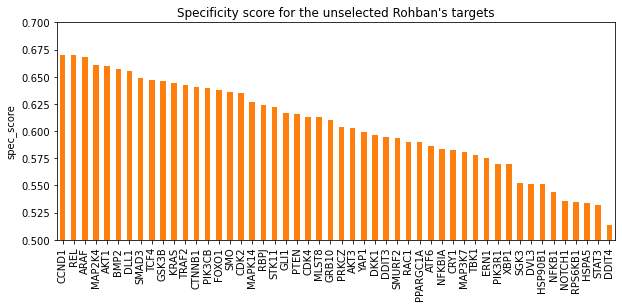

<IPython.core.display.Javascript object>

In [135]:
unselected_rohban_targets = (rohban_targets - selected_targets).intersection(
    spec_results.index
)
spec_results.loc[unselected_rohban_targets].sort_values(
    "spec_score", ascending=False
).spec_score.plot.bar(figsize=[10, 4], color="tab:orange")
plt.ylabel("spec_score")
plt.title("Specificity score for the unselected Rohban's targets")
plt.ylim([0.5, 0.7])
plt.show()

As described earlier that could be due to the pooling of all replicates on a gene level in our screening or because of higher level of conservativeness in choosing the respective targets. For instance we see that 27/50 targets reach a specificity score of above 0.6 which that the ensemble model could distinguish between the overexpression condition and the negative controls with an accuracy of roughly 0.6.

Next, we look at the genes that were selected by our screen yet no corresponding alleles was found to yield a specific structural phenotype according to the definition of Rohban et al.

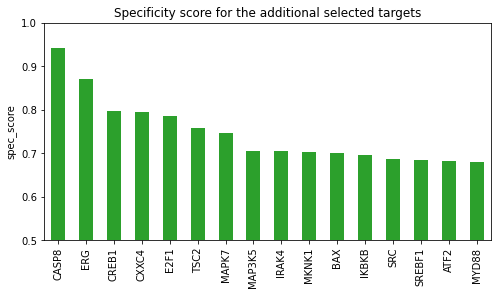

<IPython.core.display.Javascript object>

In [150]:
additional_targets = (selected_targets - rohban_targets).intersection(
    spec_results.index
)
spec_results.loc[additional_targets].sort_values(
    "spec_score", ascending=False
).spec_score.plot.bar(figsize=[8, 4], color="tab:green")
plt.ylabel("spec_score")
plt.title("Specificity score for the additional selected targets")
plt.ylim([0.5, 1.0])
plt.show()

We see that among the additionally selected targets are three targets that were identified to be (highly) toxic namely CASP8, ERG, CXXC4 both yielding a very specific structural phenotype at least at the populational level in the decrease of the cell density. This feature is only partly captured by the morphological profiles via features that assess the distance to the nearest neighbor. Additionally we find 5 known transcription factors in the set of additionally selected genes, namely CREB1, E2F1, BAX, SREBF1, ATF2. The remaining genes are TSC2, MAPK7, MAP3K5, IRAK4, MKNK1, IKBKB, MYD88 and SRC, where SRC is known to play a role in the mechano-transduction pathways.

Finally, we save the set of selected targets.

In [168]:
spec_results["selected"] = False
spec_results.loc[selected_targets, "selected"] = True
spec_results.to_csv("../../../data/other/specificity_screen_results.csv")

<IPython.core.display.Javascript object>

---

## 5. Visualization of the screen embeddings

Finally, we will visualize the individual embeddings of the control and OE condition samples for the training, validation and test set of our ensemble method for the specific targets to provide further empirical evidence of the specificity of the structural phenotypes of the cells in those settings.

Visualize latent spaces:   0%|          | 0/190 [00:00<?, ?it/s]

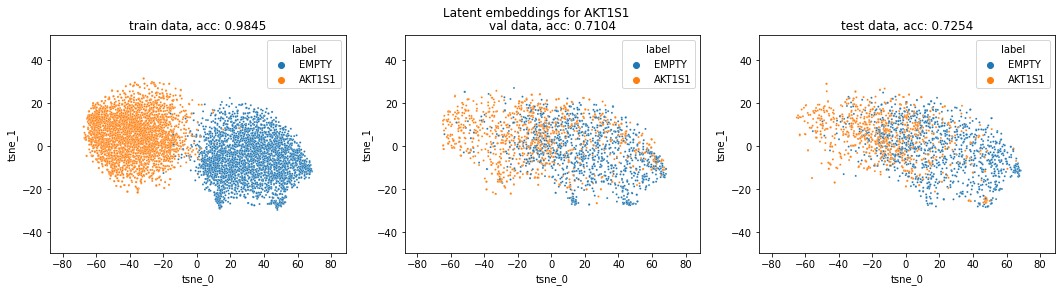

Visualize latent spaces:   2%|▏         | 4/190 [00:21<16:50,  5.43s/it]

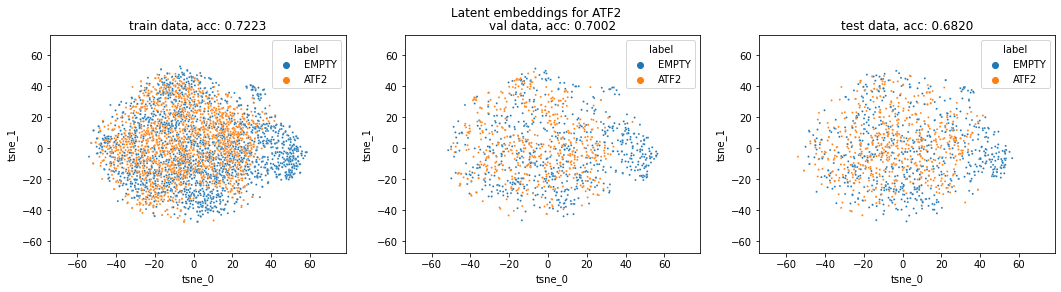

Visualize latent spaces:   6%|▌         | 11/190 [00:34<08:35,  2.88s/it]

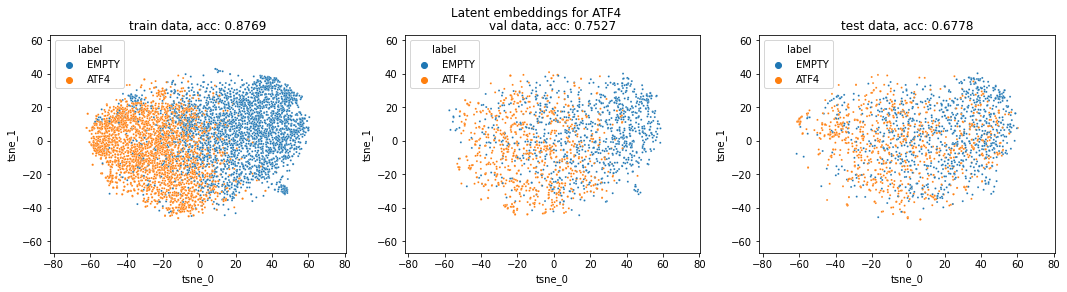

Visualize latent spaces:   6%|▋         | 12/190 [00:53<14:29,  4.88s/it]

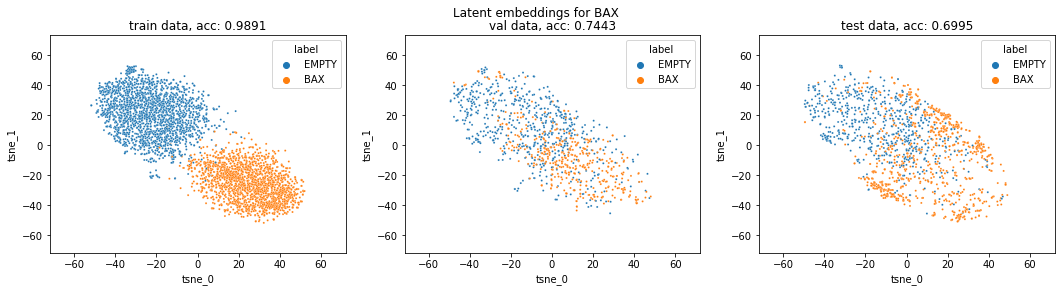

Visualize latent spaces:  10%|█         | 19/190 [01:05<08:46,  3.08s/it]

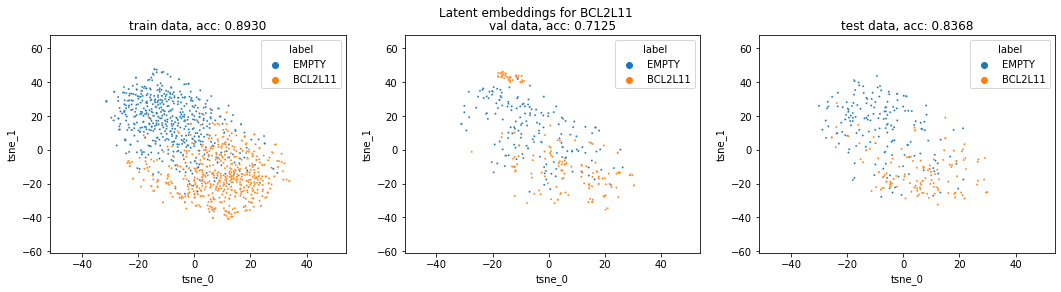

Visualize latent spaces:  11%|█         | 21/190 [01:08<08:03,  2.86s/it]

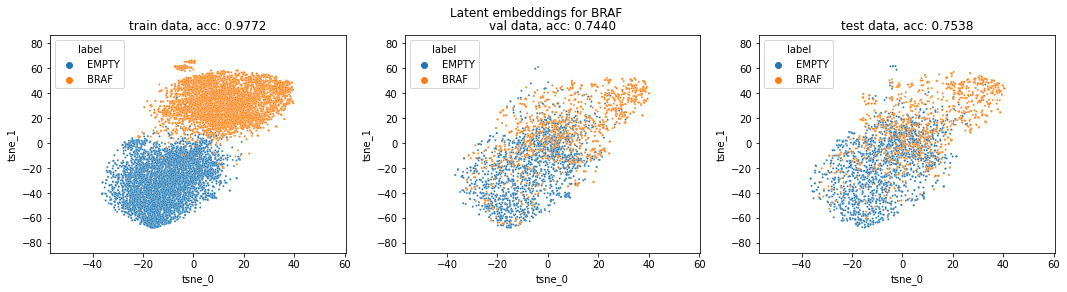

Visualize latent spaces:  13%|█▎        | 25/190 [01:45<13:46,  5.01s/it]

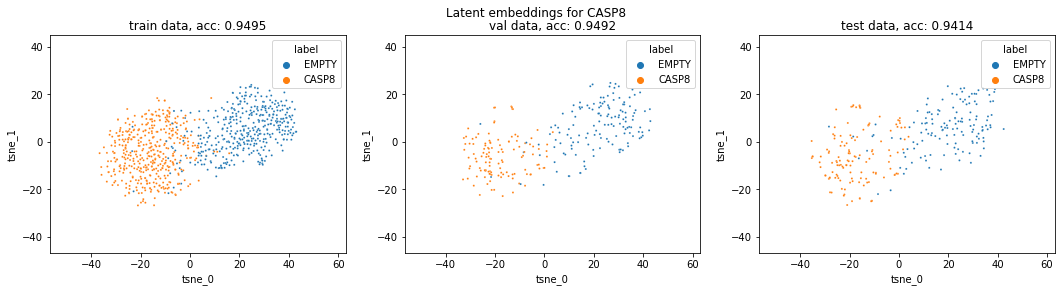

Visualize latent spaces:  15%|█▌        | 29/190 [01:47<09:36,  3.58s/it]

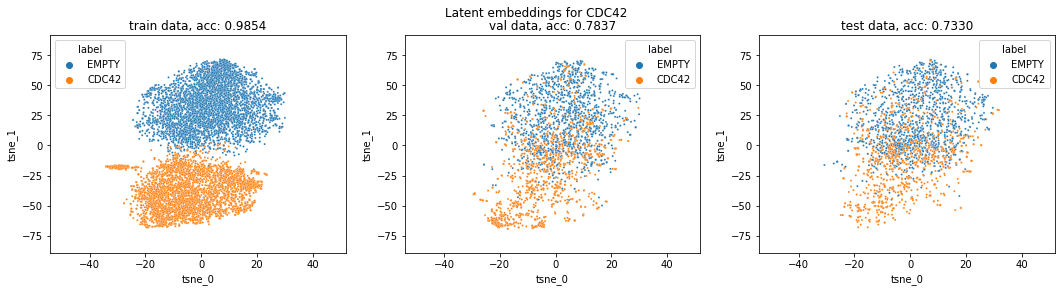

Visualize latent spaces:  17%|█▋        | 33/190 [02:14<11:55,  4.55s/it]

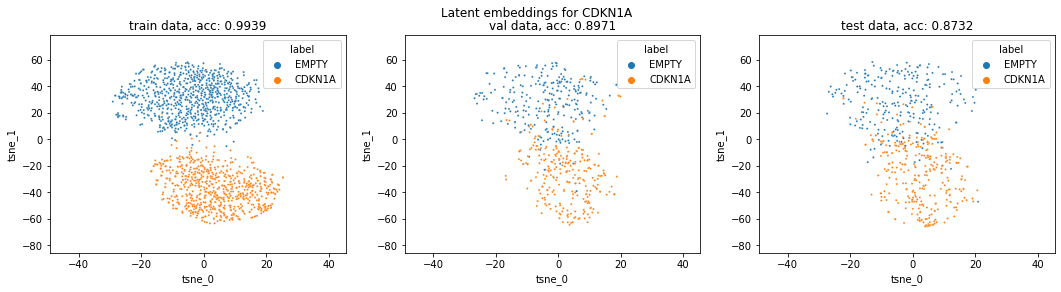

Visualize latent spaces:  19%|█▉        | 36/190 [02:19<09:48,  3.82s/it]

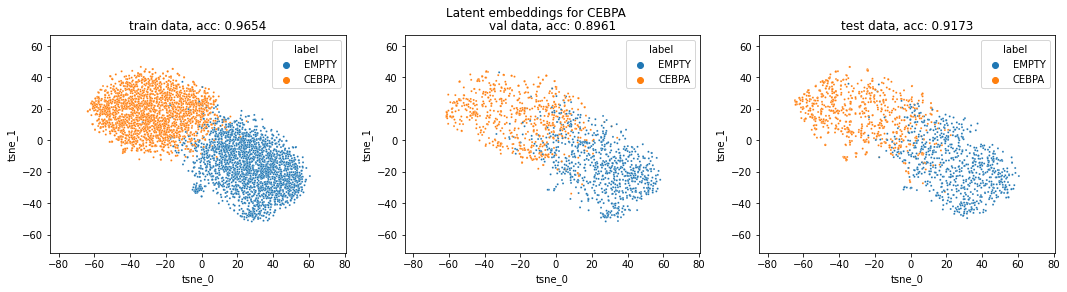

Visualize latent spaces:  19%|█▉        | 37/190 [02:33<12:42,  4.98s/it]

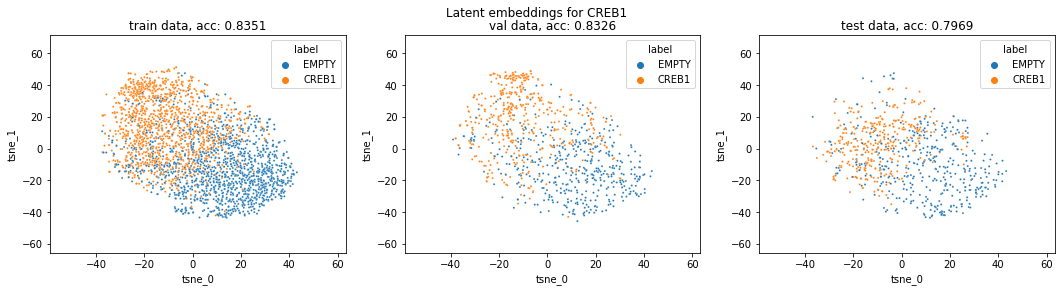

Visualize latent spaces:  21%|██        | 40/190 [02:42<10:42,  4.28s/it]

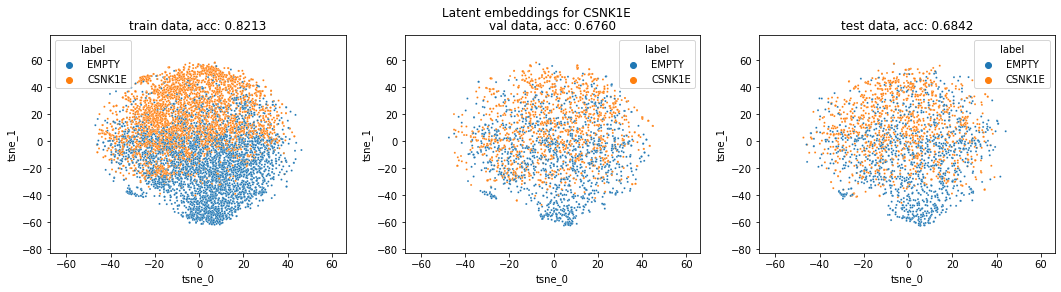

Visualize latent spaces:  23%|██▎       | 44/190 [03:07<12:17,  5.05s/it]

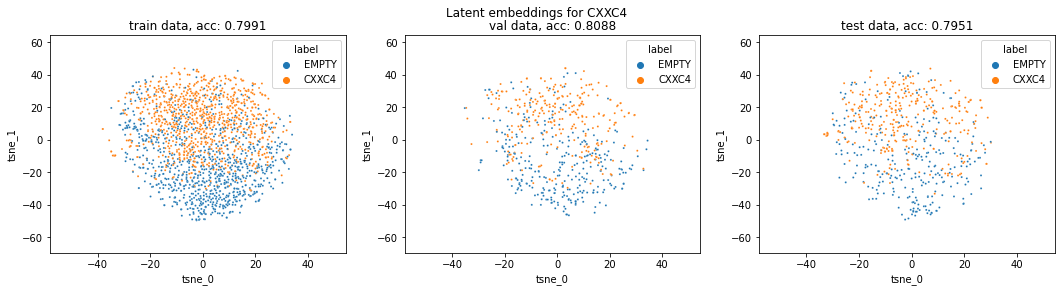

Visualize latent spaces:  24%|██▍       | 46/190 [03:13<11:04,  4.61s/it]

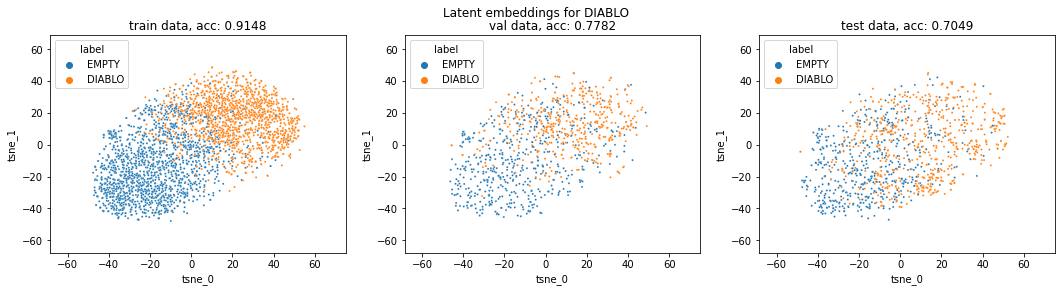

Visualize latent spaces:  27%|██▋       | 51/190 [03:23<08:00,  3.45s/it]

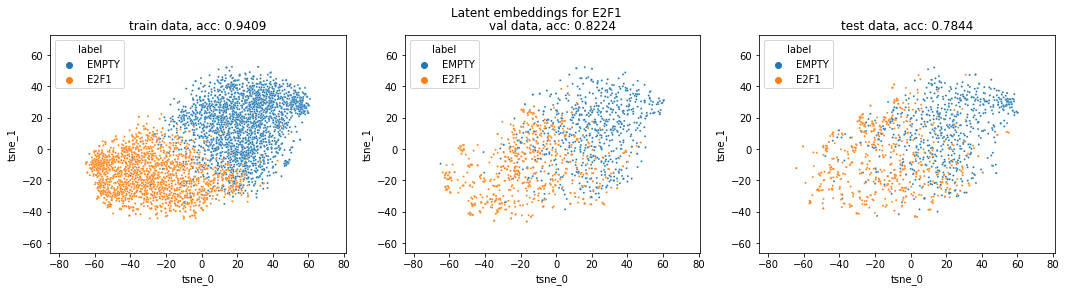

Visualize latent spaces:  31%|███       | 58/190 [03:35<05:53,  2.68s/it]

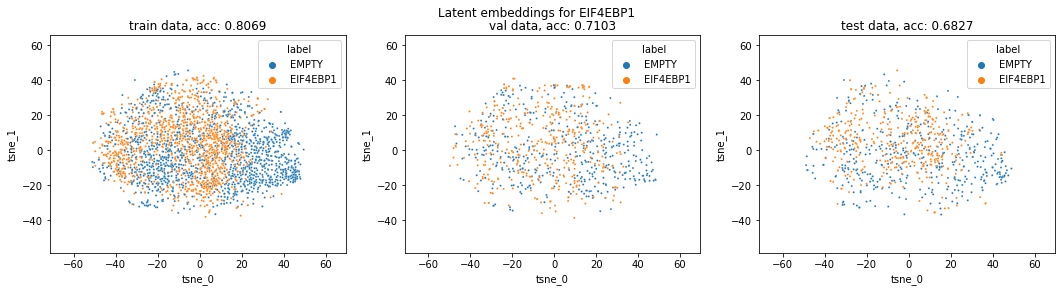

Visualize latent spaces:  33%|███▎      | 62/190 [03:44<05:26,  2.55s/it]

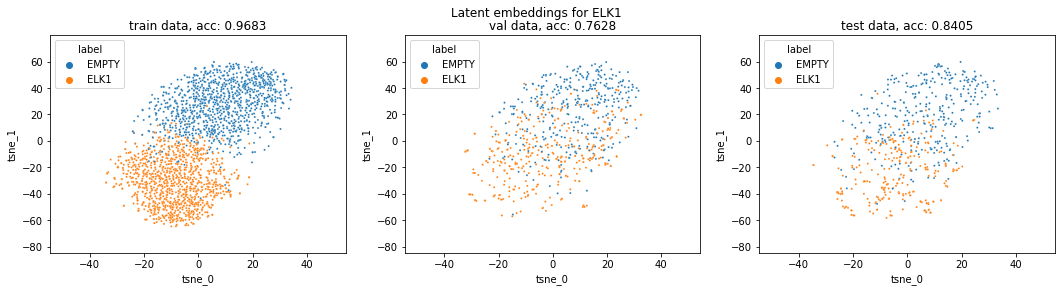

Visualize latent spaces:  33%|███▎      | 63/190 [03:50<06:08,  2.90s/it]

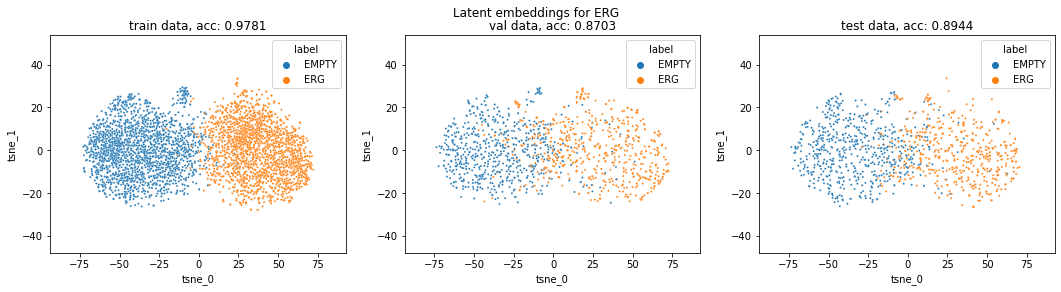

Visualize latent spaces:  34%|███▍      | 65/190 [04:03<07:29,  3.60s/it]

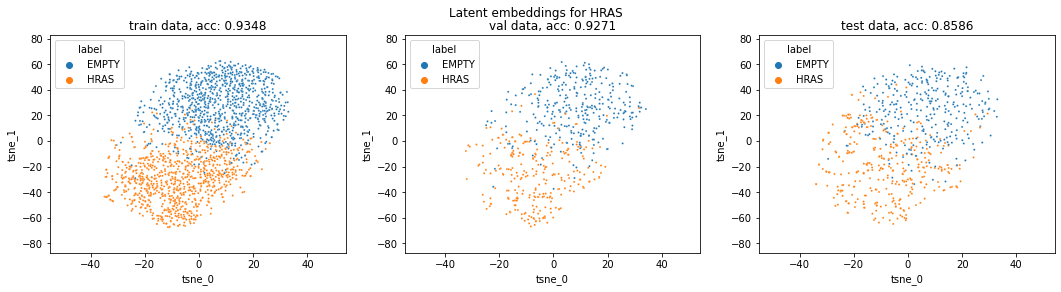

Visualize latent spaces:  40%|████      | 76/190 [04:09<03:17,  1.73s/it]

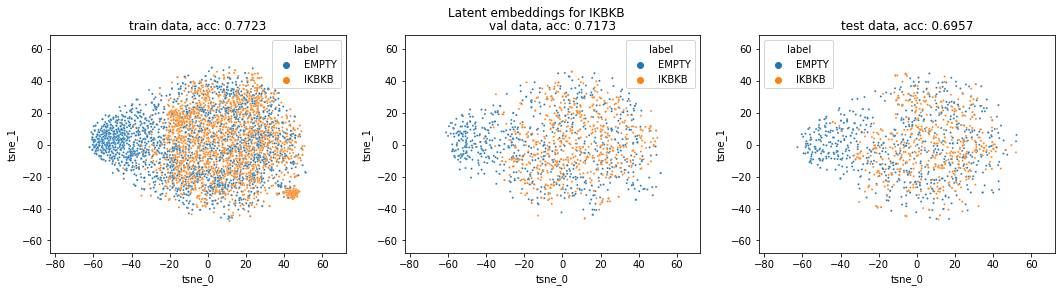

Visualize latent spaces:  42%|████▏     | 80/190 [04:22<03:51,  2.10s/it]

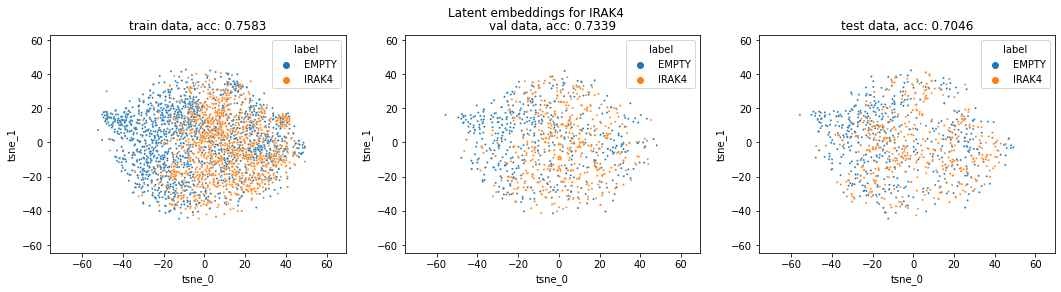

Visualize latent spaces:  44%|████▎     | 83/190 [04:31<04:05,  2.30s/it]

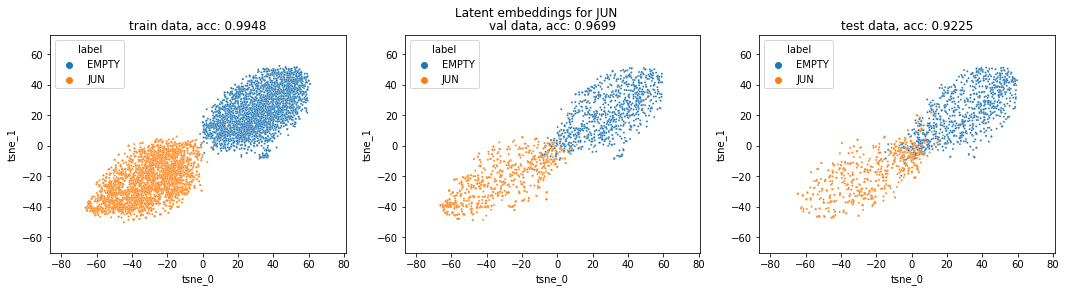

Visualize latent spaces:  46%|████▋     | 88/190 [04:47<04:21,  2.56s/it]

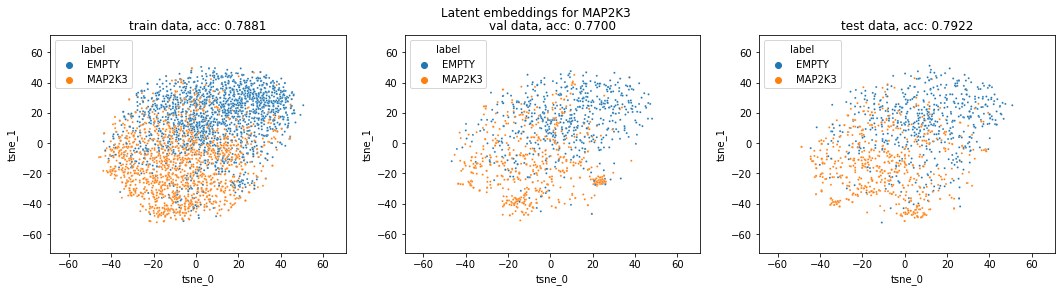

Visualize latent spaces:  48%|████▊     | 92/190 [04:58<04:17,  2.63s/it]

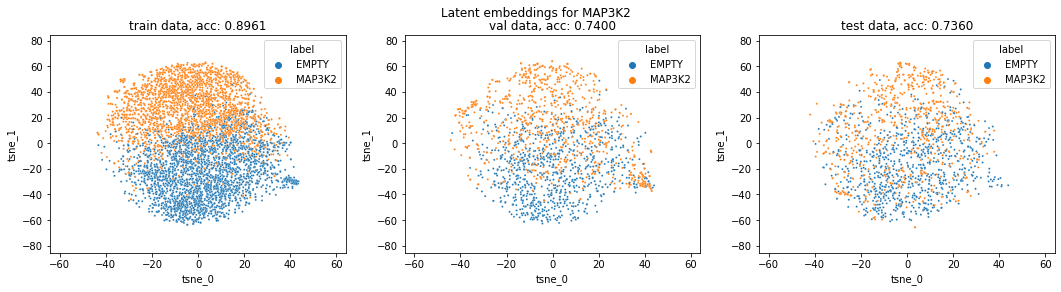

Visualize latent spaces:  50%|█████     | 95/190 [05:15<05:16,  3.34s/it]

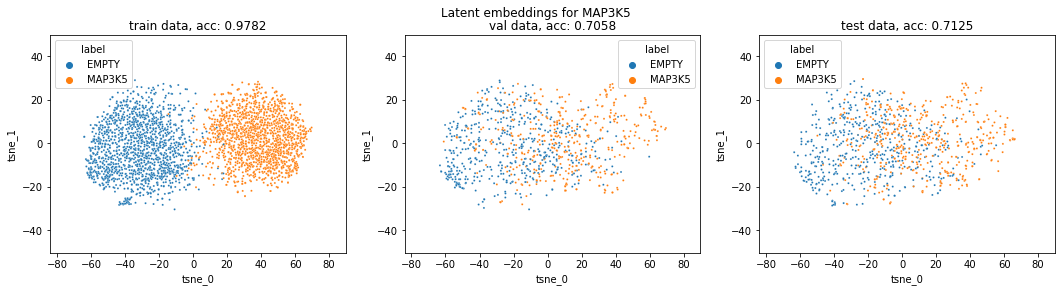

Visualize latent spaces:  51%|█████     | 96/190 [05:25<06:13,  3.97s/it]

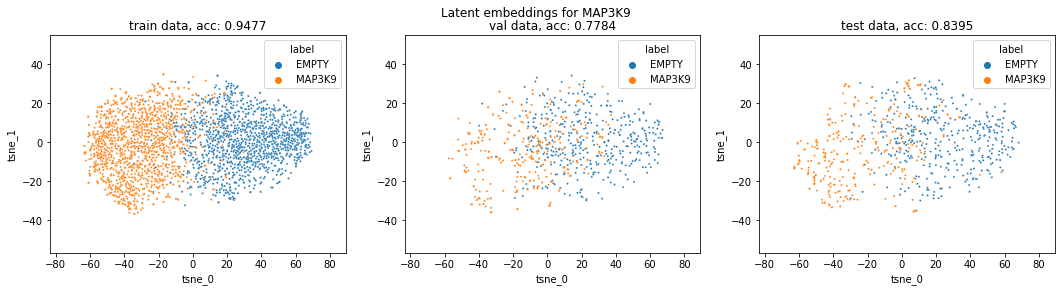

Visualize latent spaces:  52%|█████▏    | 99/190 [05:33<05:28,  3.61s/it]

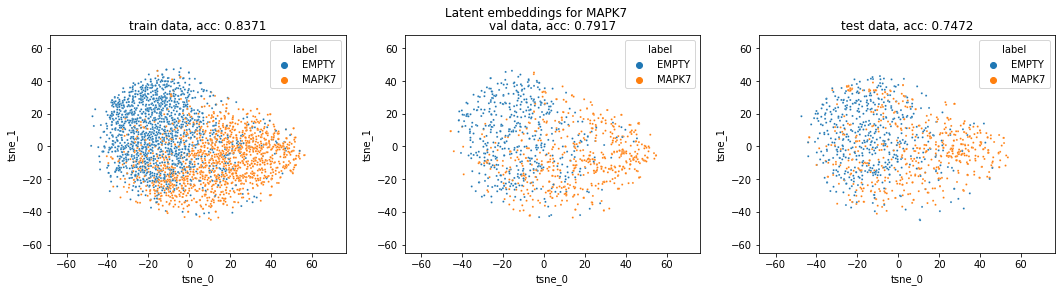

Visualize latent spaces:  55%|█████▍    | 104/190 [05:43<04:13,  2.94s/it]

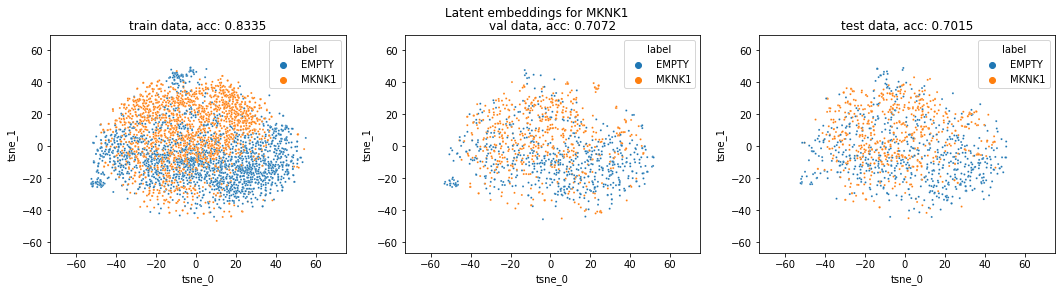

Visualize latent spaces:  58%|█████▊    | 110/190 [05:56<03:28,  2.61s/it]

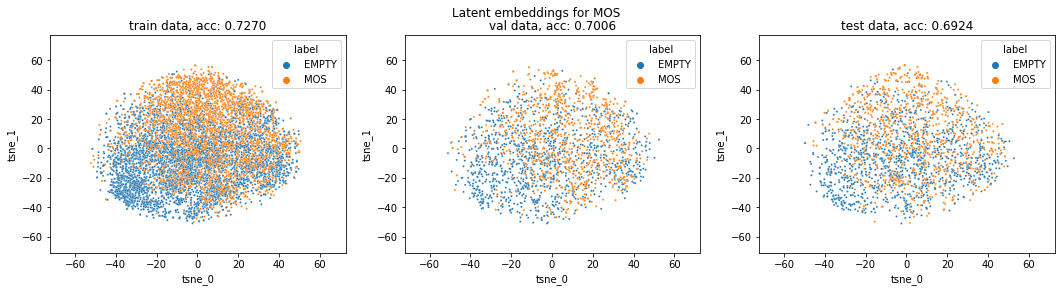

Visualize latent spaces:  59%|█████▉    | 112/190 [06:22<05:33,  4.27s/it]

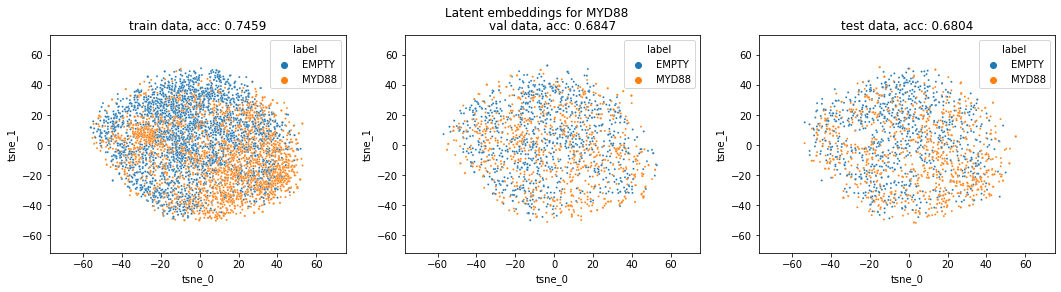

Visualize latent spaces:  59%|█████▉    | 113/190 [06:39<07:14,  5.65s/it]

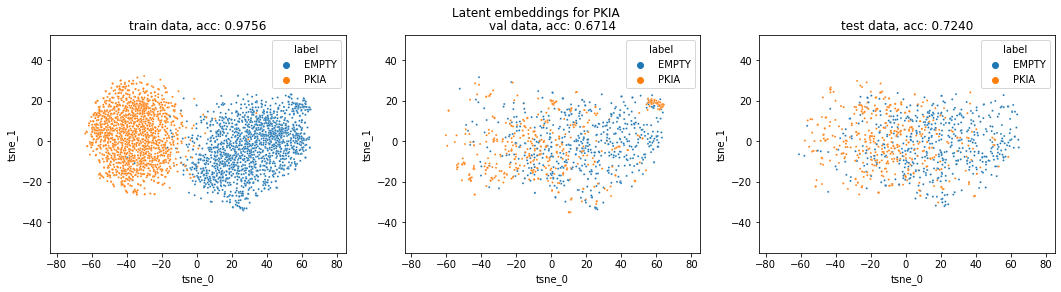

Visualize latent spaces:  68%|██████▊   | 130/190 [06:49<02:01,  2.02s/it]

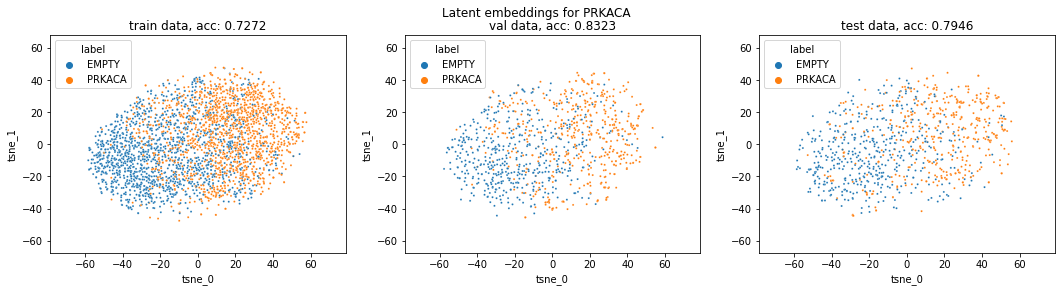

Visualize latent spaces:  71%|███████   | 134/190 [07:00<01:59,  2.13s/it]

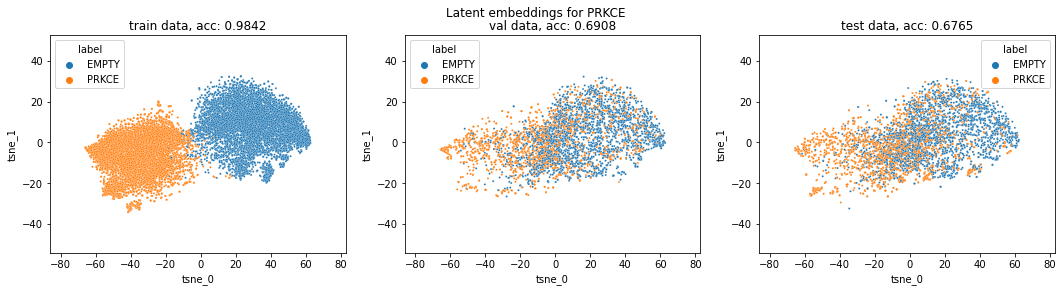

Visualize latent spaces:  72%|███████▏  | 137/190 [07:49<04:02,  4.58s/it]

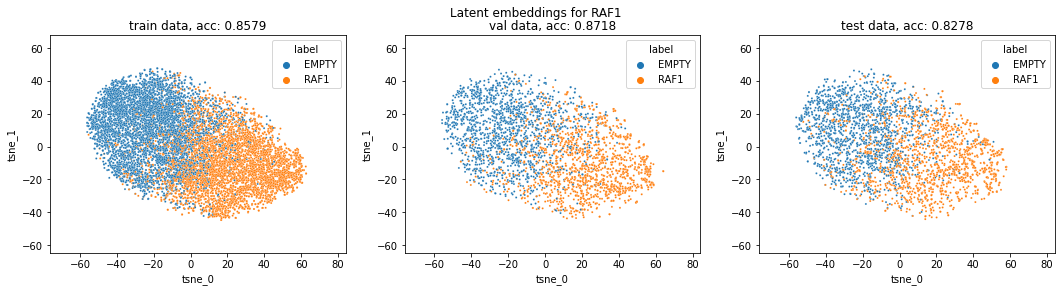

Visualize latent spaces:  75%|███████▍  | 142/190 [08:22<04:09,  5.19s/it]

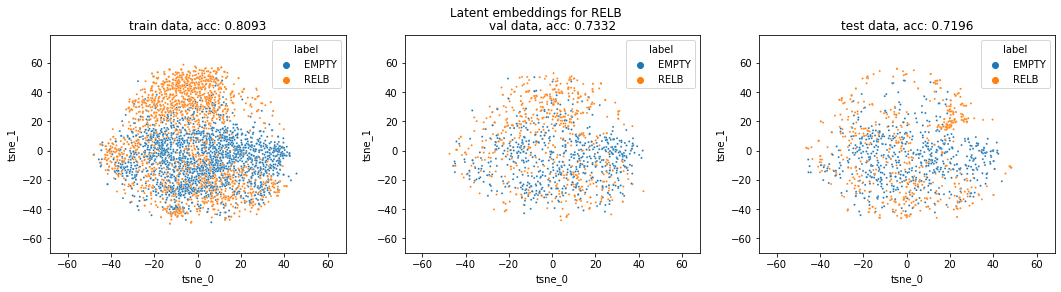

Visualize latent spaces:  77%|███████▋  | 147/190 [08:35<03:09,  4.42s/it]

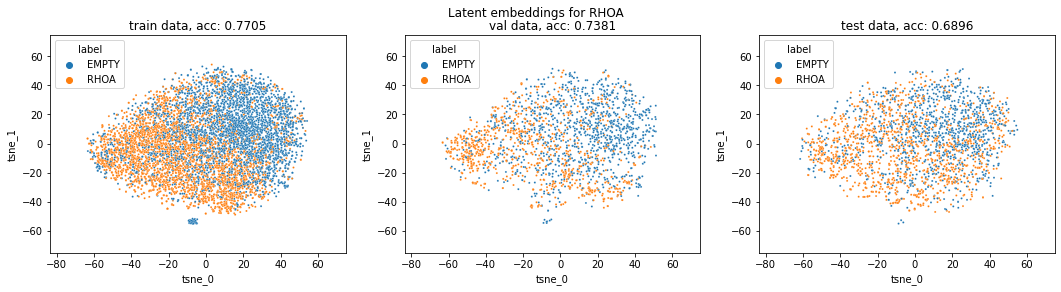

Visualize latent spaces:  78%|███████▊  | 149/190 [08:59<03:45,  5.49s/it]

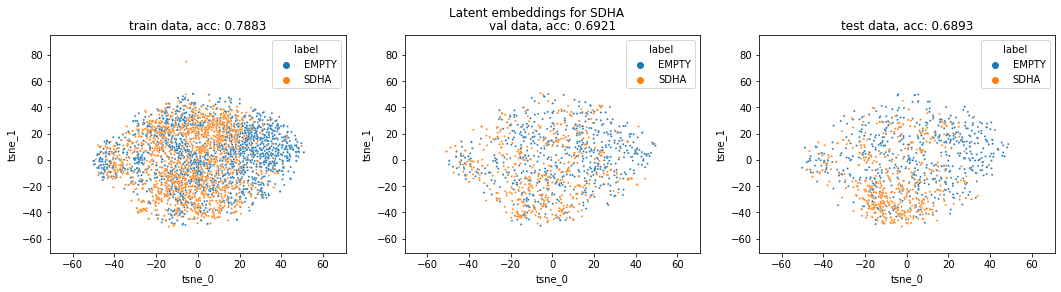

Visualize latent spaces:  81%|████████  | 154/190 [09:10<02:37,  4.39s/it]

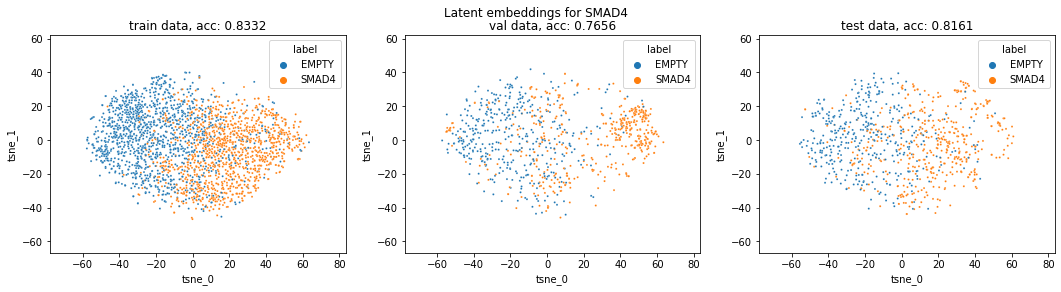

Visualize latent spaces:  83%|████████▎ | 158/190 [09:18<01:59,  3.72s/it]

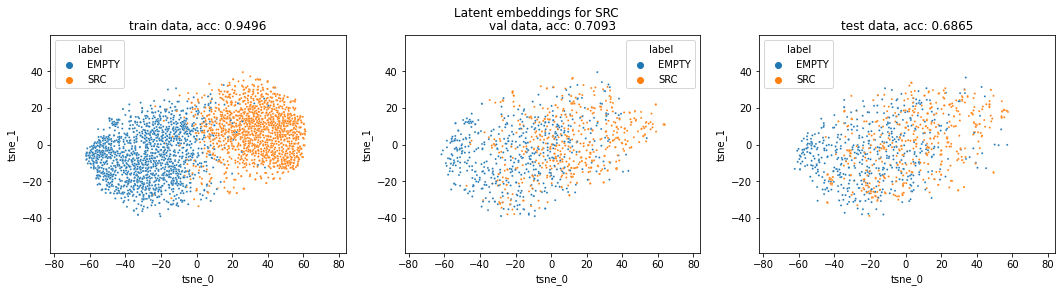

Visualize latent spaces:  86%|████████▋ | 164/190 [09:28<01:16,  2.94s/it]

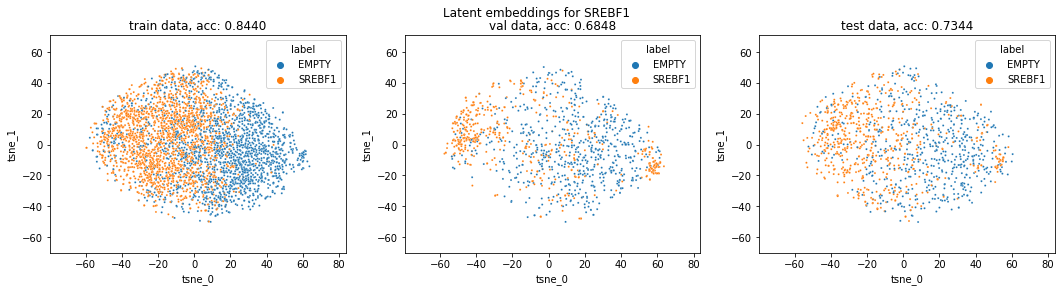

Visualize latent spaces:  87%|████████▋ | 165/190 [09:39<01:31,  3.65s/it]

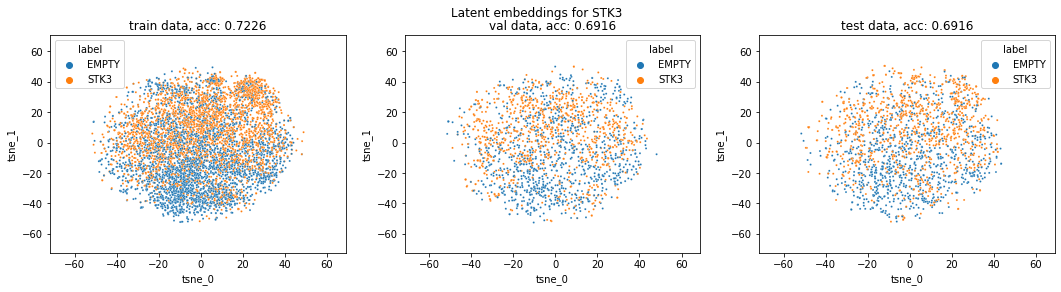

Visualize latent spaces:  89%|████████▉ | 169/190 [10:00<01:26,  4.12s/it]

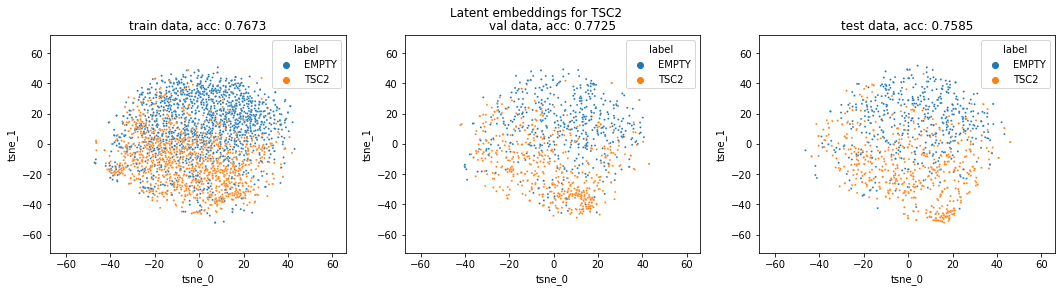

Visualize latent spaces:  96%|█████████▌| 182/190 [10:10<00:17,  2.16s/it]

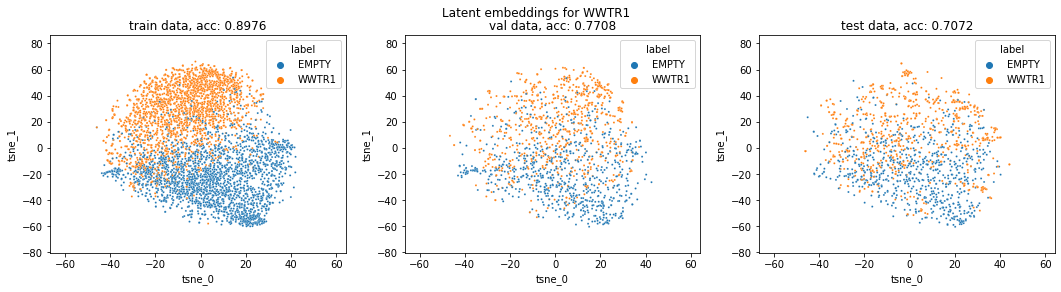

Visualize latent spaces: 100%|██████████| 190/190 [10:27<00:00,  3.30s/it]


<IPython.core.display.Javascript object>

In [167]:
plot_spec_screen_results(
    root_dir="../../../data/experiments/image_embeddings/nuclei_fov_screen/",
    score_df=screen_results_multi_image,
    dataset_types=["train", "val", "test"],
    figsize=[18, 4],
    filter_targets=selected_targets,
)